In [23]:
import numpy as np
import pandas as pd
from datetime import datetime

import vectorbt as vbt

from dffc.holt_winters._holt_winters import HW, HWDP

In [24]:
from dffc.fund_data import register_fund_data

register_fund_data()

FundData already exists in vectorbt namespace


In [25]:
try:
    prices = pd.read_pickle('ndgd_price.pkl')
except FileNotFoundError:
    ndgd_data = vbt.FundData.download(
        ['270042', '002963'],
        names=['ND', 'GD'],
        start='2022-01-01',
        end="2025-09-04"
    )
    import pickle

    prices = ndgd_data.get('unit_value')
    prices.to_pickle('ndgd_price.pkl')


In [26]:
from dffc.holt_winters.holtwinter_op_list import process_hw_opt

result = process_hw_opt(prices, ".", 8)

开始处理 2 个基金...
处理基金 1/2: 270042


Optimizing seasons: 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]



  基金 270042 处理完成！参数: Alpha=0.148575, Beta=0.008383, Gamma=0.096186, Season=23
处理基金 2/2: 002963


Optimizing seasons: 100%|██████████| 18/18 [00:05<00:00,  3.09it/s]



  基金 002963 处理完成！参数: Alpha=0.083851, Beta=0.003999, Gamma=0.463343, Season=15

批量处理完成!
成功处理: 2 个基金
处理失败: 0 个基金
汇总结果保存在: ./processing_summary.csv


In [7]:
result

[{'fundcode': '270042',
  'status': 'success',
  'data_points': 894,
  'alpha': np.float64(0.14857530769607186),
  'beta': np.float64(0.008383115294243518),
  'gamma': np.float64(0.09618626135013343),
  'season': np.int64(23),
  'rss': np.float64(4.461374276706412)},
 {'fundcode': '002963',
  'status': 'success',
  'data_points': 894,
  'alpha': np.float64(0.08385099784395998),
  'beta': np.float64(0.003998619474013655),
  'gamma': np.float64(0.46334306969731265),
  'season': np.int64(15),
  'rss': np.float64(0.22078426848091867)}]

In [27]:
# Create HW models for each fund using parameters from result
hwdps = {}
for fund_result in result:
    fundcode = fund_result['fundcode']
    hwdp = HWDP.run(
        prices[fundcode], 
        alpha=fund_result['alpha'],
        beta=fund_result['beta'],
        gamma=fund_result['gamma'],
        m=fund_result['season'], 
        multiplicative=True
    )
    hwdps[fundcode] = hwdp


In [28]:
# 基于HWDP差值的资产配置策略
import numpy as np

# 获取两个资产的HWDP值
hwdp_270042 = hwdps['270042'].hwdp  # ND基金
hwdp_002963 = hwdps['002963'].hwdp  # GD基金

# 计算HWDP差值 (ND - GD)
hwdp_diff = hwdp_270042 - hwdp_002963

# 初始化权重数组
weights_270042 = np.zeros_like(hwdp_diff)
weights_002963 = np.zeros_like(hwdp_diff)

# 初始权重设定
current_weight_270042 = 0.5  # 初始50%
current_weight_002963 = 0.5  # 初始50%

# 策略逻辑：当差值>=1.2或<=-1.2时调整权重
for i in range(len(hwdp_diff)):
    if hwdp_diff[i] >= 1.2:
        # ND相对强势，增加ND权重到80%，GD权重降到20%
        current_weight_270042 = 0.8
        current_weight_002963 = 0.2
    elif hwdp_diff[i] <= -1.2:
        # GD相对强势，增加GD权重到80%，ND权重降到20%
        current_weight_270042 = 0.2
        current_weight_002963 = 0.8
    # 否则保持当前权重不变
    
    weights_270042[i] = current_weight_270042
    weights_002963[i] = current_weight_002963

# 创建权重DataFrame
weights_df = pd.DataFrame({
    'ND_weight': weights_270042,
    'GD_weight': weights_002963,
    'hwdp_diff': hwdp_diff
}, index=prices.index)

print("策略权重分配完成")
print(f"权重调整次数: {np.sum(np.diff(weights_270042) != 0) + np.sum(np.diff(weights_002963) != 0)}")
print("\n最近10天权重分配:")
print(weights_df.tail(10))

策略权重分配完成
权重调整次数: 42

最近10天权重分配:
                           ND_weight  GD_weight  hwdp_diff
date                                                      
2025-08-22 00:00:00+08:00        0.8        0.2   0.276018
2025-08-25 00:00:00+08:00        0.8        0.2   0.099323
2025-08-26 00:00:00+08:00        0.8        0.2   0.067720
2025-08-27 00:00:00+08:00        0.8        0.2  -0.067568
2025-08-28 00:00:00+08:00        0.8        0.2   0.144144
2025-08-29 00:00:00+08:00        0.8        0.2  -0.552809
2025-09-01 00:00:00+08:00        0.2        0.8  -1.294382
2025-09-02 00:00:00+08:00        0.2        0.8  -1.475336
2025-09-03 00:00:00+08:00        0.2        0.8  -1.336323
2025-09-04 00:00:00+08:00        0.2        0.8  -1.064877


/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/3624397434.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/3624397434.py:25: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [22]:
hwdp_diff

date
2022-01-04 00:00:00+08:00    0.000000
2022-01-05 00:00:00+08:00    0.000000
2022-01-06 00:00:00+08:00    0.000000
2022-01-07 00:00:00+08:00    0.000000
2022-01-10 00:00:00+08:00    1.000000
                               ...   
2025-08-29 00:00:00+08:00   -0.552809
2025-09-01 00:00:00+08:00   -1.294382
2025-09-02 00:00:00+08:00   -1.475336
2025-09-03 00:00:00+08:00   -1.336323
2025-09-04 00:00:00+08:00   -1.064877
Length: 894, dtype: float64

目标权重示例:
                           270042  002963
date                                     
2022-01-04 00:00:00+08:00     0.5     0.5
2022-01-05 00:00:00+08:00     0.5     0.5
2022-01-06 00:00:00+08:00     0.5     0.5
2022-01-07 00:00:00+08:00     0.5     0.5
2022-01-10 00:00:00+08:00     0.5     0.5

重新平衡次数: 22

=== 策略回测结果 ===
策略总收益: 39.12%
策略年化收益: 14.43%
策略夏普比率: 1.38
策略最大回撤: -12.98%

=== 基准回测结果 ===
基准总收益: 31.21%
基准年化收益: 11.70%
基准夏普比率: 1.38
基准最大回撤: -10.76%

=== 策略 vs 基准对比 ===
超额收益: 7.90%

=== 投资组合价值 ===
期初价值: 199990.00
期末价值: 278232.06
总收益: 39.12%

=== 交易统计 ===
总交易次数: 1780
总手续费: 318.50

=== 权重调整统计 ===
权重调整次数: 21
调整频率: 2.3%


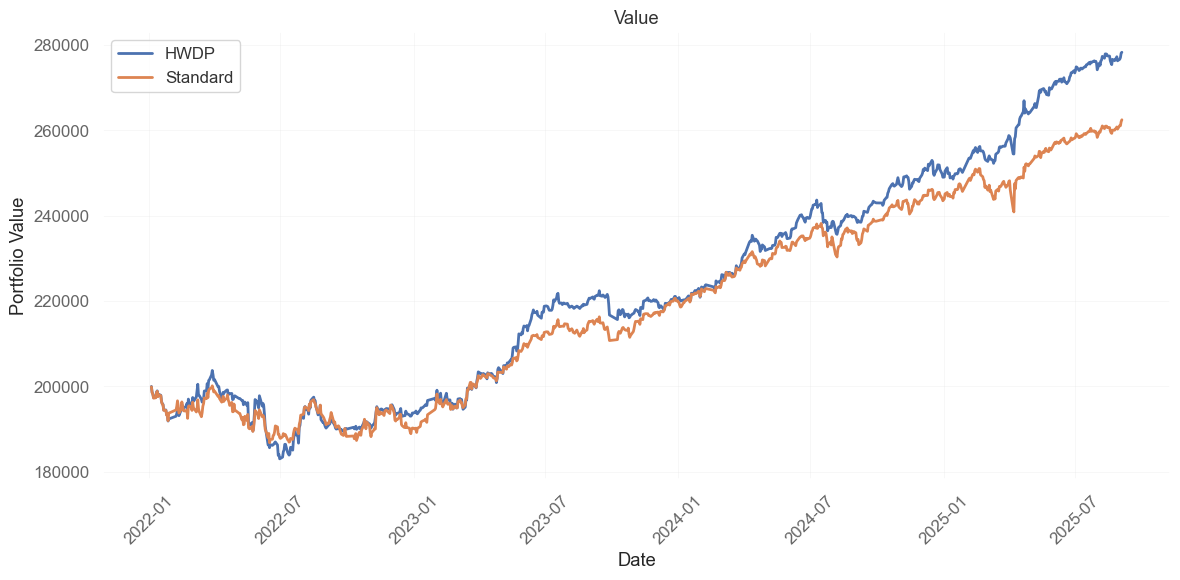

In [36]:
# 使用vectorbt进行真正的回测
import vectorbt as vbt

# 创建目标权重DataFrame
target_weights = pd.DataFrame({
    '270042': weights_270042,
    '002963': weights_002963
}, index=prices.index)

print("目标权重示例:")
print(target_weights.head())

# 生成重新平衡信号 - 当权重发生变化时进行调仓
rebalance_signals = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=bool)

# 第一天设为True（初始买入）
rebalance_signals.iloc[0] = True

# 当权重发生变化时设为True
for i in range(1, len(target_weights)):
    if (target_weights.iloc[i] != target_weights.iloc[i-1]).any():
        rebalance_signals.iloc[i] = True
    else:
        rebalance_signals.iloc[i] = False

print(f"\n重新平衡次数: {rebalance_signals.any(axis=1).sum()}")

# 使用vectorbt的Portfolio.from_orders进行回测
pf = vbt.Portfolio.from_orders(
    close=prices,
    size=target_weights * 100000,  # 总资金100000，按权重分配
    size_type='targetvalue',  # 目标价值
    price=prices,
    fees=0.0001,  # 0.1%手续费
    freq='D',
    init_cash=100000
)

# 创建基准组合（等权重买入持有）
benchmark_weights = pd.DataFrame(0.5, index=prices.index, columns=prices.columns)
benchmark_pf = vbt.Portfolio.from_orders(
    close=prices,
    size=benchmark_weights * 100000,
    size_type='targetvalue',
    price=prices,
    fees=0.001,
    freq='D',
    init_cash=100000
)

print("\n=== 策略回测结果 ===")
print(f"策略总收益: {pf.total_return().mean():.2%}")
print(f"策略年化收益: {pf.annualized_return().mean():.2%}")
print(f"策略夏普比率: {pf.sharpe_ratio().mean():.2f}")
print(f"策略最大回撤: {pf.max_drawdown().mean():.2%}")

print("\n=== 基准回测结果 ===")
print(f"基准总收益: {benchmark_pf.total_return().mean():.2%}")
print(f"基准年化收益: {benchmark_pf.annualized_return().mean():.2%}")
print(f"基准夏普比率: {benchmark_pf.sharpe_ratio().mean():.2f}")
print(f"基准最大回撤: {benchmark_pf.max_drawdown().mean():.2%}")

print("\n=== 策略 vs 基准对比 ===")
strategy_return = pf.total_return().mean()
benchmark_return = benchmark_pf.total_return().mean()
print(f"超额收益: {(strategy_return - benchmark_return):.2%}")

# 显示投资组合价值变化
print("\n=== 投资组合价值 ===")
portfolio_value = pf.value()
print(f"期初价值: {portfolio_value.iloc[0].sum():.2f}")
print(f"期末价值: {portfolio_value.iloc[-1].sum():.2f}")
print(f"总收益: {(portfolio_value.iloc[-1].sum() / portfolio_value.iloc[0].sum() - 1):.2%}")

# 显示交易统计
print(f"\n=== 交易统计 ===")
total_orders = pf.orders.count().sum()
total_fees = pf.orders.fees.sum().sum()
print(f"总交易次数: {total_orders}")
print(f"总手续费: {total_fees:.2f}")

# 显示权重调整统计
weight_changes = np.diff(weights_270042) != 0
print(f"\n=== 权重调整统计 ===")
print(f"权重调整次数: {np.sum(weight_changes)}")
print(f"调整频率: {np.sum(weight_changes) / len(weights_270042) * 100:.1f}%")

# 绘制投资组合价值曲线对比
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    portfolio_total = portfolio_value.sum(axis=1)
    benchmark_total = benchmark_pf.value().sum(axis=1)
    
    plt.plot(portfolio_total.index, portfolio_total.values, label='HWDP', linewidth=2)
    plt.plot(benchmark_total.index, benchmark_total.values, label='Standard', linewidth=2)
    plt.title('Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except:
    print("绘图功能暂不可用，但回测数据已成功计算")

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/2107695867.py:41: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/2107695867.py:42: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/2107695867.py:83: UserWarning:

Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) Arial.

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/2107695867.py:83: UserWarning:

Glyph 36164 (\N{CJK UNIFIED IDEOGR

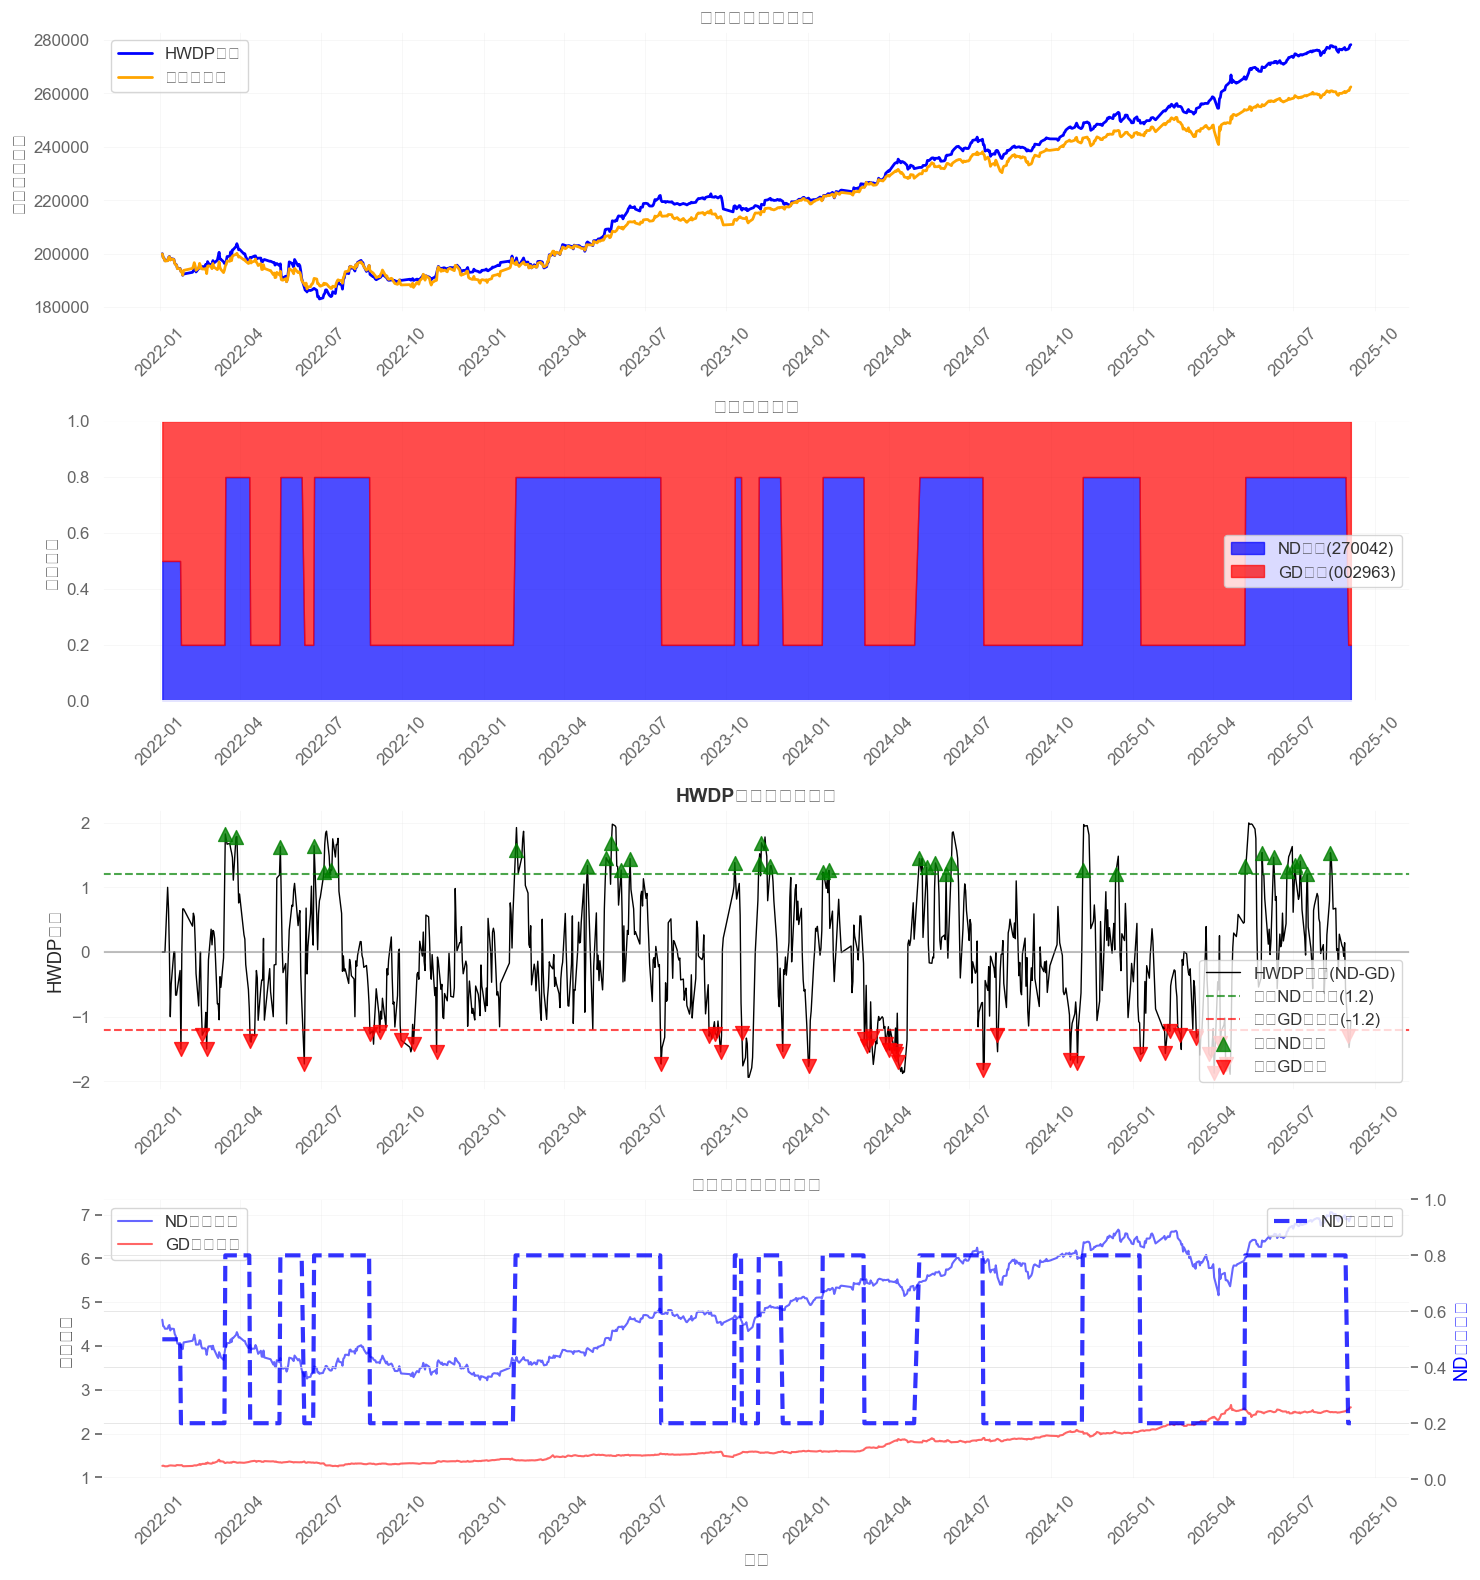

=== 交易信号详细统计 ===
买入ND信号次数: 33
买入GD信号次数: 39
总信号次数: 72

买入ND信号日期:
  2022-03-16: HWDP差值 = 1.826
  2022-03-28: HWDP差值 = 1.778
  2022-05-17: HWDP差值 = 1.628
  2022-06-24: HWDP差值 = 1.643
  2022-07-05: HWDP差值 = 1.233
  2022-07-13: HWDP差值 = 1.270
  2023-02-06: HWDP差值 = 1.573
  2023-04-28: HWDP差值 = 1.337
  2023-05-19: HWDP差值 = 1.458
  2023-05-25: HWDP差值 = 1.690
  2023-06-05: HWDP差值 = 1.267
  2023-06-15: HWDP差值 = 1.443
  2023-10-11: HWDP差值 = 1.383
  2023-11-07: HWDP差值 = 1.354
  2023-11-10: HWDP差值 = 1.689
  2023-11-20: HWDP差值 = 1.333
  2024-01-18: HWDP差值 = 1.237
  2024-01-25: HWDP差值 = 1.262
  2024-05-06: HWDP差值 = 1.447
  2024-05-14: HWDP差值 = 1.312
  2024-05-24: HWDP差值 = 1.377
  2024-06-05: HWDP差值 = 1.208
  2024-06-11: HWDP差值 = 1.376
  2024-11-06: HWDP差值 = 1.264
  2024-12-13: HWDP差值 = 1.201
  2025-05-08: HWDP差值 = 1.323
  2025-05-27: HWDP差值 = 1.538
  2025-06-09: HWDP差值 = 1.465
  2025-06-24: HWDP差值 = 1.259
  2025-07-03: HWDP差值 = 1.344
  2025-07-09: HWDP差值 = 1.404
  2025-07-17: HWDP差值 = 1.203
  2025-0

In [41]:
# 详细分析图表
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 创建子图
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# 1. 投资组合净值对比
portfolio_total = pf.value().sum(axis=1)
benchmark_total = benchmark_pf.value().sum(axis=1)

axes[0].plot(portfolio_total.index, portfolio_total.values, label='HWDP策略', linewidth=2, color='blue')
axes[0].plot(benchmark_total.index, benchmark_total.values, label='等权重基准', linewidth=2, color='orange')
axes[0].set_title('投资组合净值对比', fontsize=14, fontweight='bold')
axes[0].set_ylabel('投资组合价值')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 资产权重变化
axes[1].fill_between(target_weights.index, 0, target_weights['270042'], 
                    alpha=0.7, label='ND基金(270042)', color='blue')
axes[1].fill_between(target_weights.index, target_weights['270042'], 1, 
                    alpha=0.7, label='GD基金(002963)', color='red')
axes[1].set_title('资产权重变化', fontsize=14, fontweight='bold')
axes[1].set_ylabel('权重比例')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# 3. HWDP差值和交易信号
axes[2].plot(hwdp_diff.index, hwdp_diff.values, color='black', linewidth=1, label='HWDP差值(ND-GD)')
axes[2].axhline(y=1.2, color='green', linestyle='--', alpha=0.7, label='买入ND信号线(1.2)')
axes[2].axhline(y=-1.2, color='red', linestyle='--', alpha=0.7, label='买入GD信号线(-1.2)')
axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# 标记买入卖出信号
buy_nd_signals = hwdp_diff >= 1.2
buy_gd_signals = hwdp_diff <= -1.2

# 找到信号变化点
buy_nd_changes = buy_nd_signals & ~buy_nd_signals.shift(1).fillna(False)
buy_gd_changes = buy_gd_signals & ~buy_gd_signals.shift(1).fillna(False)

if buy_nd_changes.any():
    axes[2].scatter(hwdp_diff[buy_nd_changes].index, hwdp_diff[buy_nd_changes].values, 
                   color='green', marker='^', s=100, alpha=0.8, label='买入ND信号', zorder=5)

if buy_gd_changes.any():
    axes[2].scatter(hwdp_diff[buy_gd_changes].index, hwdp_diff[buy_gd_changes].values, 
                   color='red', marker='v', s=100, alpha=0.8, label='买入GD信号', zorder=5)

axes[2].set_title('HWDP差值与交易信号', fontsize=14, fontweight='bold')
axes[2].set_ylabel('HWDP差值')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 4. 个股价格走势与权重叠加
ax4_twin = axes[3].twinx()

# 绘制价格（左轴）
axes[3].plot(prices.index, prices['270042'], color='blue', alpha=0.6, label='ND基金价格')
axes[3].plot(prices.index, prices['002963'], color='red', alpha=0.6, label='GD基金价格')
axes[3].set_ylabel('基金净值', color='black')
axes[3].legend(loc='upper left')

# 绘制ND基金权重（右轴）
ax4_twin.plot(target_weights.index, target_weights['270042'], 
             color='blue', linewidth=3, alpha=0.8, linestyle='--', label='ND基金权重')
ax4_twin.set_ylabel('ND基金权重', color='blue')
ax4_twin.set_ylim(0, 1)
ax4_twin.legend(loc='upper right')

axes[3].set_title('个股价格与权重变化', fontsize=14, fontweight='bold')
axes[3].set_xlabel('日期')
axes[3].grid(True, alpha=0.3)

# 设置x轴格式
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.tight_layout()
plt.show()

# 交易信号统计
print("=== 交易信号详细统计 ===")
print(f"买入ND信号次数: {buy_nd_changes.sum()}")
print(f"买入GD信号次数: {buy_gd_changes.sum()}")
print(f"总信号次数: {buy_nd_changes.sum() + buy_gd_changes.sum()}")

# 显示信号发生的日期
if buy_nd_changes.any():
    print(f"\n买入ND信号日期:")
    for date in hwdp_diff[buy_nd_changes].index:
        print(f"  {date.strftime('%Y-%m-%d')}: HWDP差值 = {hwdp_diff[date]:.3f}")

if buy_gd_changes.any():
    print(f"\n买入GD信号日期:")
    for date in hwdp_diff[buy_gd_changes].index:
        print(f"  {date.strftime('%Y-%m-%d')}: HWDP差值 = {hwdp_diff[date]:.3f}")

# 权重分布统计
print(f"\n=== 权重分布统计 ===")
weight_dist = target_weights['270042'].value_counts().sort_index()
print("ND基金权重分布:")
for weight, count in weight_dist.items():
    print(f"  {weight*100:.0f}%权重: {count}天 ({count/len(target_weights)*100:.1f}%)")

print(f"\n平均权重: ND基金 {target_weights['270042'].mean():.1%}, GD基金 {target_weights['002963'].mean():.1%}")

=== Vectorbt 提供的绘图功能 ===
1. Portfolio对象的绘图方法:
   - pf.plot()              # 综合投资组合图表
   - pf.plot_cum_returns()  # 累计收益图
   - pf.plot_drawdowns()    # 回撤分析图
   - pf.plot_positions()    # 持仓分析图

2. 子对象的绘图方法:
   - pf.orders.plot()       # 订单图表
   - pf.trades.plot()       # 交易图表
   - pf.drawdowns.plot()    # 详细回撤图

3. 通用绘图方法:
   - data.vbt.plot()        # 任何Series/DataFrame的绘图
   - data.vbt.histplot()    # 直方图
   - data.vbt.boxplot()     # 箱线图

=== 实际演示 ===
1. 投资组合统计信息:

策略关键指标:
  Total Return [%]: 39.12
  Max Drawdown [%]: 12.98
  Sharpe Ratio: 1.38

基准关键指标:
  Total Return [%]: 31.21
  Max Drawdown [%]: 10.76
  Sharpe Ratio: 1.38

2. 投资组合价值对比图:


/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/773320298.py:27: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x1045ce200>. Pass column to select a single column/group.

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/773320298.py:28: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x1045ce200>. Pass column to select a single column/group.

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/773320298.py:69: UserWarning:

Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) Arial.

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/773320298.py:69: UserWarning:

Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from font(s) Arial.

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T/ipykernel_58293/773320298.py:69: UserWarning:

Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) Arial.

/var/folders/tx/flxq3x_x53z3prbzxlmrvh040000gn/T

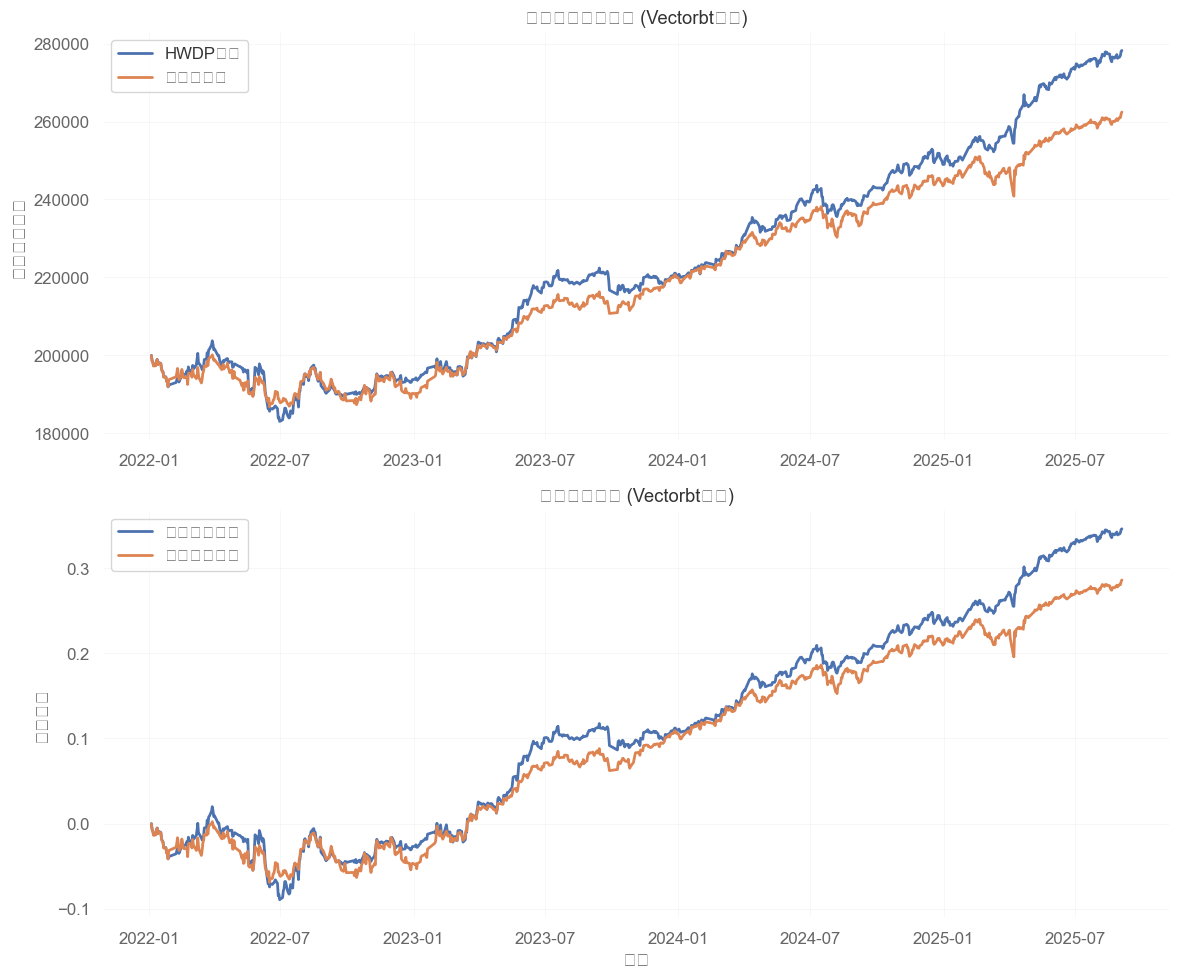


3. Vectorbt数据访问能力:
   - 订单记录: 1780 条
   - 交易记录: 983 条
   - 持仓记录: 2 条

最近5笔交易记录:
     Exit Trade Id            Column          Size           Entry Timestamp  \
978            978  (002963, 002963)     17.801623 2022-01-04 00:00:00+08:00   
979            979  (002963, 002963)    213.550459 2022-01-04 00:00:00+08:00   
980            980  (002963, 002963)    345.179833 2022-01-04 00:00:00+08:00   
981            981  (002963, 002963)     11.847987 2022-01-04 00:00:00+08:00   
982            982  (002963, 002963)  30781.069642 2022-01-04 00:00:00+08:00   

     Avg Entry Price  Entry Fees            Exit Timestamp  Avg Exit Price  \
978         2.147312    0.003823 2025-08-29 00:00:00+08:00          2.5111   
979         2.448968    0.052298 2025-09-02 00:00:00+08:00          2.5692   
980         2.448968    0.084533 2025-09-03 00:00:00+08:00          2.5980   
981         2.448968    0.002902 2025-09-04 00:00:00+08:00          2.5990   
982         2.448968    7.538186 2025-09-04 00:0

In [44]:
# Vectorbt原生绘图功能演示
print("=== Vectorbt 提供的绘图功能 ===")

# Vectorbt确实提供了丰富的绘图功能，主要包括：

print("1. Portfolio对象的绘图方法:")
print("   - pf.plot()              # 综合投资组合图表")
print("   - pf.plot_cum_returns()  # 累计收益图")
print("   - pf.plot_drawdowns()    # 回撤分析图")
print("   - pf.plot_positions()    # 持仓分析图")

print("\n2. 子对象的绘图方法:")
print("   - pf.orders.plot()       # 订单图表")
print("   - pf.trades.plot()       # 交易图表")
print("   - pf.drawdowns.plot()    # 详细回撤图")

print("\n3. 通用绘图方法:")
print("   - data.vbt.plot()        # 任何Series/DataFrame的绘图")
print("   - data.vbt.histplot()    # 直方图")
print("   - data.vbt.boxplot()     # 箱线图")

# 演示一些基本的vectorbt绘图功能（使用matplotlib后端避免依赖问题）
print("\n=== 实际演示 ===")

# 1. 获取投资组合统计信息
print("1. 投资组合统计信息:")
strategy_stats = pf.stats()
benchmark_stats = benchmark_pf.stats()

print("\n策略关键指标:")
for metric in ['Total Return [%]', 'Annualized Return [%]', 'Max Drawdown [%]', 'Sharpe Ratio']:
    if metric in strategy_stats.index:
        print(f"  {metric}: {strategy_stats[metric]:.2f}")

print("\n基准关键指标:")
for metric in ['Total Return [%]', 'Annualized Return [%]', 'Max Drawdown [%]', 'Sharpe Ratio']:
    if metric in benchmark_stats.index:
        print(f"  {metric}: {benchmark_stats[metric]:.2f}")

# 2. 投资组合价值对比（使用matplotlib替代）
print("\n2. 投资组合价值对比图:")
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 净值曲线
portfolio_value = pf.value().sum(axis=1)
benchmark_value = benchmark_pf.value().sum(axis=1)

ax1.plot(portfolio_value.index, portfolio_value.values, label='HWDP策略', linewidth=2)
ax1.plot(benchmark_value.index, benchmark_value.values, label='等权重基准', linewidth=2)
ax1.set_title('投资组合净值对比 (Vectorbt数据)')
ax1.set_ylabel('投资组合价值')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 收益对比
strategy_returns = pf.returns().mean(axis=1)
benchmark_returns = benchmark_pf.returns().mean(axis=1)

ax2.plot(strategy_returns.index, strategy_returns.cumsum(), label='策略累计收益', linewidth=2)
ax2.plot(benchmark_returns.index, benchmark_returns.cumsum(), label='基准累计收益', linewidth=2)
ax2.set_title('累计收益对比 (Vectorbt计算)')
ax2.set_ylabel('累计收益')
ax2.set_xlabel('日期')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 展示vectorbt的数据访问能力
print("\n3. Vectorbt数据访问能力:")
print(f"   - 订单记录: {len(pf.orders.records_readable)} 条")
print(f"   - 交易记录: {len(pf.trades.records_readable)} 条") 
print(f"   - 持仓记录: {len(pf.positions.records_readable)} 条")

print("\n最近5笔交易记录:")
if len(pf.trades.records_readable) > 0:
    print(pf.trades.records_readable.tail())
else:
    print("无交易记录")

print("\n=== Vectorbt的优势 ===")
print("✓ 高性能的向量化计算")
print("✓ 丰富的内置指标和统计功能")
print("✓ 完整的交易记录和分析")
print("✓ 灵活的绘图接口")
print("✓ 支持多种回测策略")
print("✓ 内置风险管理功能")